# Homework 7/8

### Snow Hydrology

### Clinton Alden

In [10]:
import pandas as pd
from metloom.pointdata import SnotelPointData
import altair as alt
import numpy as np
from metpy.units import units
import numpy as np
import altair as alt
alt.data_transformers.disable_max_rows()
import matplotlib.pyplot as plt
import datetime as dt
import xarray as xr

# Problem 1 
Temperature-Index Method For this problem, we will use the Temperature-Index method for predicting snow melt, discussed in Module 7 and introduced in Lab 7-3.

## a)
Calculate Mf using measurements from the Schofield Pass Snotel station and report your value. I.E. mimic Lab 7-3 but for measurements from a different Snotel station. Use the same date range, 1990-2024. Note that we downloaded and used Schofield pass data in Lab 2-1.


In [3]:
df_schofield_longterm = pd.read_csv('/Users/clintonalden/Documents/grad_school/cewa568_W25/data/schofield_longterm.csv')
df_butte_longterm = pd.read_csv('/Users/clintonalden/Documents/grad_school/cewa568_W25/data/butte_longterm.csv')

df = df_schofield_longterm
def melt_rate(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['date_no_year'] = df['datetime'].apply(
        lambda dt: dt.replace(year=1999) if dt.month in [10,11,12] else dt.replace(year=2000)
    )

    delta_swe = df.groupby('year').apply(lambda df: df.set_index('datetime')[['SWE']].diff())
    delta_swe = delta_swe.rename(columns={'SWE': 'Delta SWE'})

    delta_swe = delta_swe[delta_swe.index.get_level_values(1).month > 3] 
    delta_swe = delta_swe[delta_swe.index.get_level_values(1).month < 7]
    delta_swe = delta_swe[delta_swe['Delta SWE'] < 0]
    delta_swe['MELT RATE'] = - delta_swe['Delta SWE']

    delta_swe = delta_swe.reset_index().set_index('datetime').join(
        df.set_index('datetime')[['MAX AIR TEMP', 'PRECIPITATION']]
    )

    delta_swe['Delta SWE'] = (delta_swe['Delta SWE'].values * units('inches')).to(units('millimeters')).magnitude
    delta_swe['MAX AIR TEMP'] = (delta_swe['MAX AIR TEMP'].values * units('degF')).to(units('degC')).magnitude
    delta_swe['PRECIPITATION'] = (delta_swe['PRECIPITATION'].values * units('inches')).to(units('millimeters')).magnitude
    delta_swe['MELT RATE'] = (delta_swe['MELT RATE'].values * units('inches')).to(units('millimeters')).magnitude

    chart_scatter = alt.Chart(delta_swe).mark_point(size=5).encode(
        alt.X('MAX AIR TEMP:Q').title('Max daily air temp. (˚C)'),
        alt.Y('MELT RATE:Q').title('Melt rate (mm/day)')
    )
    chart_2d_histogram = alt.Chart(delta_swe).mark_rect().encode(
        alt.X('MAX AIR TEMP:Q', bin=alt.Bin(maxbins=30)).title('Max daily air temp. (˚C)'),
        alt.Y('MELT RATE:Q', bin=alt.Bin(maxbins=30)).title('Melt rate (mm/day)'),
        alt.Color('count()').title('Point Density')
    )
    (chart_scatter | chart_2d_histogram).resolve_scale(x='shared', y='shared')

    # filter data points
    src = delta_swe[delta_swe['MAX AIR TEMP'] < 25]

    # Perform linear regression with zero intercept
    x = src['MAX AIR TEMP']
    y = src['MELT RATE']
    DEGREE_DAY_FACTOR = np.sum(x * y) / np.sum(x * x)

    # Create the plot for the line of best fit
    # Line of best fit using the slope (DEGREE_DAY_FACTOR) and zero intercept
    line = alt.Chart(src).mark_line(color='red').encode(
        alt.X('MAX AIR TEMP:Q'),
        alt.Y('MELT RATE:Q')
    ).transform_calculate(
        "MELT RATE", f"{DEGREE_DAY_FACTOR} * datum['MAX AIR TEMP']"
    )

    # Add it to the charts above.
    # Add the estimated degree day factor (the DEGREE_DAY_FACTOR of the line of best fit)
    #    to the charts.
    (
        (chart_scatter + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')  
        | 
        (chart_2d_histogram + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')
    ).resolve_scale(x='shared', y='shared')
    

    return DEGREE_DAY_FACTOR

In [7]:
# Load data
df_schofield_longterm = pd.read_csv('/Users/clintonalden/Documents/grad_school/cewa568_W25/data/schofield_longterm.csv')
df_butte_longterm = pd.read_csv('/Users/clintonalden/Documents/grad_school/cewa568_W25/data/butte_longterm.csv')

def M_f_calc(df):
    df['datetime'] = pd.to_datetime(df['datetime'])
    df['year'] = df['datetime'].dt.year
    df['date_no_year'] = df['datetime'].apply(lambda dt: dt.replace(year=1999) if dt.month in [10,11,12] else dt.replace(year=2000))

    delta_swe = df.groupby('year').apply(lambda df: df.set_index('datetime')[['SWE']].diff())
    delta_swe = delta_swe.rename(columns={'SWE': 'Delta SWE'})

    delta_swe = delta_swe[delta_swe.index.get_level_values(1).month > 3] 
    delta_swe = delta_swe[delta_swe.index.get_level_values(1).month < 7]
    delta_swe = delta_swe[delta_swe['Delta SWE'] < 0]
    delta_swe['MELT RATE'] = - delta_swe['Delta SWE']

    delta_swe = delta_swe.reset_index().set_index('datetime').join(
        df.set_index('datetime')[['MAX AIR TEMP', 'PRECIPITATION']]
    )

    delta_swe['Delta SWE'] = (delta_swe['Delta SWE'].values * units('inches')).to(units('millimeters')).magnitude
    delta_swe['MAX AIR TEMP'] = (delta_swe['MAX AIR TEMP'].values * units('degF')).to(units('degC')).magnitude
    delta_swe['PRECIPITATION'] = (delta_swe['PRECIPITATION'].values * units('inches')).to(units('millimeters')).magnitude
    delta_swe['MELT RATE'] = (delta_swe['MELT RATE'].values * units('inches')).to(units('millimeters')).magnitude

    # filter data points
    src = delta_swe[delta_swe['MAX AIR TEMP'] < 25]

    # Perform linear regression with zero intercept
    x = src['MAX AIR TEMP']
    y = src['MELT RATE']
    DEGREE_DAY_FACTOR = np.sum(x * y) / np.sum(x * x)

    # Create the plot for the line of best fit
    # Line of best fit using the slope (DEGREE_DAY_FACTOR) and zero intercept
    line = alt.Chart(src).mark_line(color='red').encode(
        alt.X('MAX AIR TEMP:Q'),
        alt.Y('MELT RATE:Q')
    ).transform_calculate(
        "MELT RATE", f"{DEGREE_DAY_FACTOR} * datum['MAX AIR TEMP']"
    )

    # Add it to the charts above.
    chart_scatter = alt.Chart(delta_swe).mark_point(size=5).encode(
        alt.X('MAX AIR TEMP:Q').title('Max daily air temp. (˚C)'),
        alt.Y('MELT RATE:Q').title('Melt rate (mm/day)')
    )
    chart_2d_histogram = alt.Chart(delta_swe).mark_rect().encode(
        alt.X('MAX AIR TEMP:Q', bin=alt.Bin(maxbins=30)).title('Max daily air temp. (˚C)'),
        alt.Y('MELT RATE:Q', bin=alt.Bin(maxbins=30)).title('Melt rate (mm/day)'),
        alt.Color('count()').title('Point Density')
    )
    combined_chart = (
        (chart_scatter + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')  
        | 
        (chart_2d_histogram + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')
    ).resolve_scale(x='shared', y='shared')

    # Display the combined chart inline in a Jupyter Notebook
    combined_chart.display()


M_f_calc(df_schofield_longterm)
print('M_f for Schofield: 1.74mm/˚C/day')

# print('M_f for Butte:')
# M_f_calc(df_butte_longterm)

/var/folders/db/7c91t8d577n1zsyhth1xc7840000gn/T/ipykernel_23768/1516901514.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  delta_swe = df.groupby('year').apply(lambda df: df.set_index('datetime')[['SWE']].diff())


alt.HConcatChart(...)

M_f for Schofield: 1.74mm/˚C/day


## b)
Compare Mf values calculated at the Butte and Schofield Pass Snotel stations. Explain why you think one is larger/smaller than the other.

In [8]:
# from lab 7-3
print('M_f for Butte: 1.19mm/˚C/day')

print('M_f for Schofield: 1.74mm/˚C/day')

M_f for Butte: 1.19mm/˚C/day
M_f for Schofield: 1.74mm/˚C/day


#### Answer 
The melt rate at thes two sites might have something to do with the exposure to sun at each site. If the Schofield Pass site is in a sunnier location, its melt season will be shorter. It would then appear as though the melt rate per degree C was higher because more melt occured at the same temperature when compared to a potentially shadier Butte site.

## c)
 Choose an Mf value calculated from either the Butte or Schofield Pass Snotel stations, and model snowpack ablation at Kettle Ponds. I.E. mimic the second half of Lab 7-3 where we modeled snowpack ablation for the Butte Snotel station, but model snowpack ablation at Kettle Ponds using air temperature measurements at Kettle Ponds. Your solution to this problem should include:

-A statement of which Mf value you selected to model snowpack ablation at Kettle Ponds, and why.

-A plot of modeled and measured SWE during the ablation period (April 1 - June 1) (I.E. create a similar plot to the final plot generated in Lab 7-3).

In [92]:
sos_dataset = xr.open_dataset('/Users/clintonalden/Documents/grad_school/cewa568_W25/data/sos_full_dataset_30min.nc')
sos_dataset = sos_dataset.sel(time=slice('2023-04-01', '2023-06-30'))

sos_precip = pd.read_csv('/Users/clintonalden/Documents/grad_school/cewa568_W25/data/kettle_ponds_precip.csv')
sos_precip['date'] = pd.to_datetime(sos_precip['date'])
sos_precip = sos_precip.set_index('date')
sos_precip = sos_precip.loc['2023-04-01':'2023-06-30']

sos_SWE = sos_dataset['SWE_p2_c'].to_dataframe()
sos_SWE = sos_SWE.resample('D').mean()
delta_sos_SWE = sos_SWE.diff()
sos_temp = sos_dataset['T_2m_c'].to_dataframe()
sos_temp = sos_temp.resample('D').max()
sos_precip['daily_precip_mm'] = sos_precip['acc_prec'].diff().astype(float)
sos_precip = sos_precip['daily_precip_mm']

# combine 3 dataframes
sos_df = pd.concat([delta_sos_SWE, sos_temp, sos_precip], axis=1)
sos_df['SWE'] = sos_SWE['SWE_p2_c']
sos_df['MELT RATE'] = - sos_df['SWE_p2_c']
sos_df = sos_df[sos_df['MELT RATE'] > 0]
sos_df['MAX AIR TEMP'] = sos_df['T_2m_c']
sos_df['PRECIPITATION'] = sos_df['daily_precip_mm']
sos_df.drop(columns=['SWE_p2_c', 'T_2m_c', 'daily_precip_mm'], inplace=True)

## convert SWE from inches to mm and air temp from F to C
sos_df['MELT RATE'] = (sos_df['MELT RATE'].values * units("mm"))
sos_df['MAX AIR TEMP'] = (sos_df['MAX AIR TEMP'].values * units("degC"))
sos_df['PRECIPITATION'] = (sos_df['PRECIPITATION'].values * units("mm"))
sos_df['SWE'] = (sos_df['SWE'].values * units("mm"))


In [86]:
# filter data points
src = sos_df[sos_df['MAX AIR TEMP'] < 25]

# Perform linear regression with zero intercept
x = src['MAX AIR TEMP']
y = src['MELT RATE']
DEGREE_DAY_FACTOR = np.sum(x * y) / np.sum(x * x)

In [87]:
chart_scatter = alt.Chart(sos_df).mark_point(size=5).encode(
    alt.X('MAX AIR TEMP:Q').title('Max daily air temp. (˚C)'),
    alt.Y('MELT RATE:Q').title('Melt rate (mm/day)')
)
chart_2d_histogram = alt.Chart(sos_df).mark_rect().encode(
    alt.X('MAX AIR TEMP:Q', bin=alt.Bin(maxbins=30)).title('Max daily air temp. (˚C)'),
    alt.Y('MELT RATE:Q', bin=alt.Bin(maxbins=30)).title('Melt rate (mm/day)'),
    alt.Color('count()').title('Point Density')
)
(chart_scatter | chart_2d_histogram).resolve_scale(x='shared', y='shared')

# Create the plot for the line of best fit
# Line of best fit using the slope (DEGREE_DAY_FACTOR) and zero intercept
line = alt.Chart(src).mark_line(color='red').encode(
    alt.X('MAX AIR TEMP:Q'),
    alt.Y('MELT RATE:Q')
).transform_calculate(
    "MELT RATE", f"{DEGREE_DAY_FACTOR} * datum['MAX AIR TEMP']"
)

# Add it to the charts above.
# Add the estimated degree day factor (the DEGREE_DAY_FACTOR of the line of best fit)
#    to the charts.
(
    (chart_scatter + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')  
    | 
    (chart_2d_histogram + line).properties(title=f'M_f = {round(DEGREE_DAY_FACTOR,2)} mm/˚C/day')
).resolve_scale(x='shared', y='shared')

alt.HConcatChart(...)

#### Calculate and model melt rate using schofield pass M_f

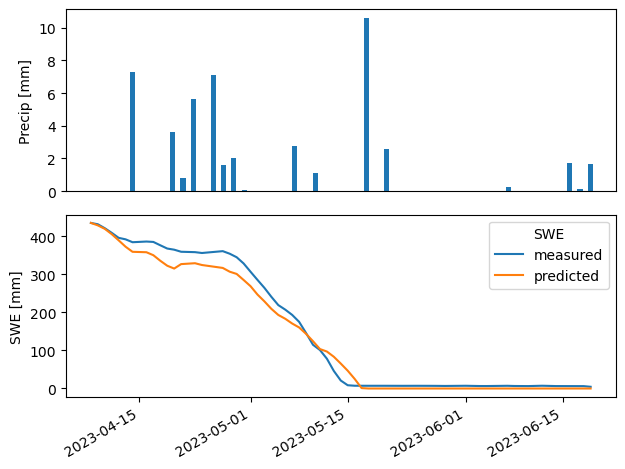

In [98]:
# sos_df['melt rate'] = sos_df['MAX AIR TEMP'] * DEGREE_DAY_FACTOR
sos_df['melt rate'] = sos_df['MAX AIR TEMP'] * 1.74

# get the initial SWE value from measurements
swe_measured_initial_value = sos_df['SWE'].iloc[0]

# calculate modeled SWE, modeling ablation using the estimated melt rates
#   First, create a list that will hold the modeled, daily SWE
modeled_swe = [swe_measured_initial_value]

#   Second, loop over melt rates from each day, calculate the new
#   SWE using the melt rate from the previous day.
for melt_rate in sos_df['melt rate']:
    updated_swe = modeled_swe[-1] - melt_rate
    if updated_swe >= 0:
        modeled_swe.append(updated_swe)
    else:
        modeled_swe.append(0)

# Add the modeled SWE back into our dataframe. We remove the last predicted SWE value because we have one day of modeled SWE beyond our measured SWE.
sos_df['SWE predicted'] = modeled_swe[:-1]

fig, axes = plt.subplots(2,1)
sos_df['SWE'].plot(label='measured', ax = axes[1])
sos_df['SWE predicted'].plot(label='predicted', ax = axes[1])
sos_df['PRECIPITATION'].plot.bar(ax=axes[0])
axes[0].set_xticks([])
axes[0].set_ylabel('Precip [mm]')
axes[1].set_ylabel('SWE [mm]')
plt.legend(title='SWE')
plt.tight_layout()

I selected Schofield Pass' degree day factor of 1.74 mm/C/day which matched observations better than Butte. Also based on my hypothesis in part b that Schofield Pass melts faster than Butte because it is sunnier, it would make sense to choose Schofield Pass to modeled melt at another sunny site like Kettle Ponds.

## d)

Explain why you think modeled and measured ablation from part c disagree. What do you know happened during the 2024 ablation period and how are those represented or not represented in the degree day factor, Mf.

#### Answer
Spring precipitation (or lack there of) was not represented in this model and is likely the source of our error. We can see that especially at the beginning of the time series, our site received precipitation and observed SWE stayed relatively constant while modeled SWE decreased.

## e)

We know that the melting of the snowpack is a result of the snowpack energy balance (see Module 4). Explain, for each term in the energy balance equation, if and how the temperature-index method incorporates the influence of that energy flux term. To help you get started, here's one part of the answer, for the ground heat flux term: The ground heat flux is not represented in the temperature-index method, because the air temperature and the ground heat flux are not related. First of all, the ground heat flux out of the earth is approximately constant, Second, snow is a great insulator, so ground heat flux is unlikely to impact air temperature. Therefore, air temperature does not incorporate the influence of the ground heat flux on snowpack melt.



#### Answer
Shortwave radiation is not accounted for directly in this model. To some extent, max air temperatures track the increase in sun angle through the spring so there is some indirect effect. Albedo, the control on outgoing shortwave radiation is not modeled here. 

Incoming longwave radiation is not modeled as this is a function of cloud cover for the most part. However, cloud cover in the spring may be somewhat correlated with max air temperatures which may indirectly impact longwave out. Outgoing longwave is not modeled as it is a function of snow surface temperature which is always 0C if the snowpack is melting.

Sensible heat flux is the main modeled value of the temperature index method, this max temperatures directly relating to sensible heat flux.

Some latent heat flux may be represented as warmer air temperatures could increase evaporation and sublimation rates.

Melt fluxes of course are represented well in this model as melting snow balances the positive energy inputs into the snowpack.

From above - 
"The ground heat flux is not represented in the temperature-index method, because the air temperature and the ground heat flux are not related. First of all, the ground heat flux out of the earth is approximately constant, Second, snow is a great insulator, so ground heat flux is unlikely to impact air temperature. Therefore, air temperature does not incorporate the influence of the ground heat flux on snowpack melt."



# Problem 2

## a) 
Lab 8-2 demonstrated that the model of the snowpack in the upper East River Valley melted out about three weeks later than the actual snowpack at Kettle Ponds. Explain, using the two plots generated in Lab 8-2 (modeled vs. measured SWE and modeled vs. measured energy balance), why you think the modeled snowpack melted out later than the measured snowpack.

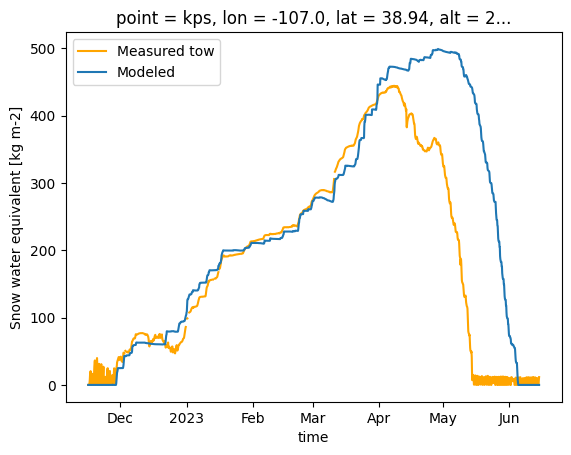

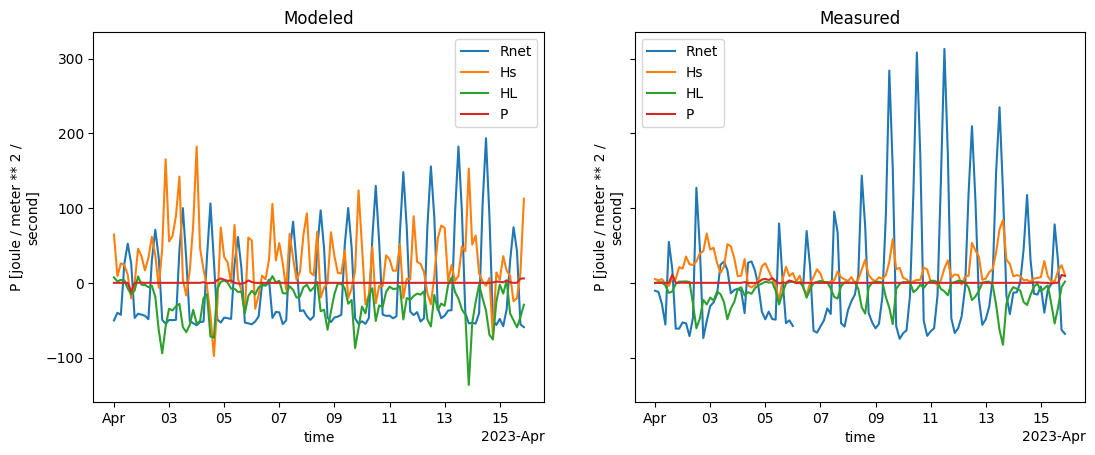

The biggest difference is that measured radiation is significantly higher than modeled radiation. This divergence happens around April 7 which coincides with the timing of a known dust on snow event.

Additionally, sensible and latent heat fluxes are slightly larger in magnitude in the modeled values versus observations.

## b)

Lab 8-2 demonstrated how the timing of snowmelt propagated spatially throughout the basin (see the 2x2 grid of snow melt plots towards the end of the lab). Explain how the spatial distribution of melt rates propagates throughout the basin, making sure to include the details of where melt starts first and why, and where it happens last and why. Explain why this spatio-temporal relationship exists.

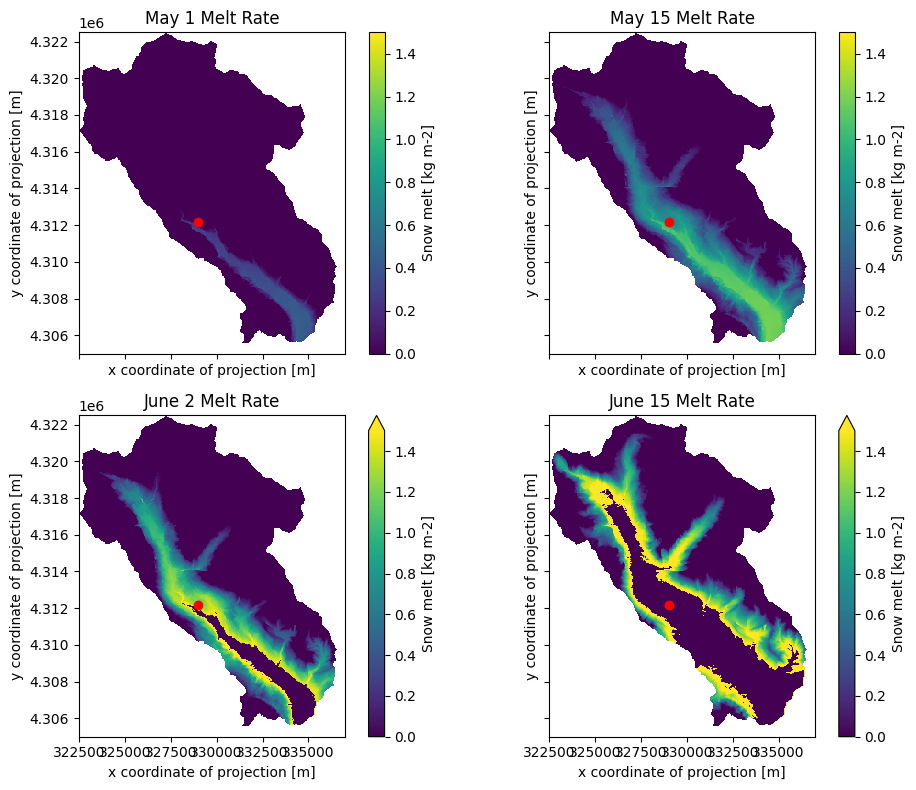

Melt began first in the lowest elevations of the East River Valley and on south facing slopes that recieve more solar radiation. As time moved on through the spring, the higher melt rates began to propogate up in elevation. Melt happens last in the highest elevations of the basin and on north facing aspects with more limited solar radiation.

Melt begins at the lowest elevation where temperatures are warmest and snow depths (and thus cold content) is generally lower. With warmer air temperatures, sensible heat flux into the snowpack is higher and therefore there is more energy available for melt. This stratification of the atmospheric temperature profile is a result of the hydrostatic and hypsometric equations balancing the pressure gradient of the troposphere.

## In the interest of time, I would like to drop the second half of this assignment

Thanks for a great class Eli!